In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
# Сделаем наши графики побольше
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

In [2]:
from pyspark.sql import SparkSession

# Инициализируем SparkSession
spark = SparkSession.builder \
    .master('local') \
    .appName('Dreamlone') \
    .config('spark.executor.memory', '2gb') \
    .config("spark.cores.max", "4") \
    .getOrCreate()

## Загрузка базы данных

Датасет представляет из себя базу данных с агрегированными параметрами по странам и по годам. Для каждой страны климатические параметры усреднялись по сельскохозяйственным землям из климатического реанализа. 

Описание полей:
* 'Precip_amount' - Количество осадков за первое полугодие, мм
* 'Precip_days' - Количество дней с осадками за первое полугодие
* 'Pressure_mean' - Среднее давление за первое полугодие, ГПа
* 'Sweden_pressure' - Среднее давление на территории Швеции, ГПа (возможно, поможет учитывать расположение центров действия атмосферы)
* 'Ireland_pressure' - Среднее давление на территории Ирландии, ГПа (возможно, поможет учитывать расположение центров действия атмосферы)
* 'Portugal_pressure' - Среднее давление на территории Португалии, ГПа (возможно, поможет учитывать расположение центров действия атмосферы)
* 'Greece_pressure' - Среднее давление на территории Греции, ГПа (возможно, поможет учитывать расположение центров действия атмосферы)
* 'Temperature_max' - Максимальная зафиксированная температура воздуха за первое полугодие, °C
* 'Temperature_min' - Минимальная зафиксированная температура воздуха за первое полугодие, °C
* 'Temperature_SAT' - Сумма активных температур выше 10°C за первое полугодие, см пример расчета в описании препроцессинга 
* 'Year' - Год с 1950 (включительно) по 2019 (не включительно)
* 'Wheat' - Урожайность пшеницы, тонн на Га
* 'Rice' - Урожайность риса, тонн на Га
* 'Maize' - Урожайность маиса, тонн на Га
* 'Potatoes' - Урожайность картошки, тонн на Га
* 'Peas' - Урожайность гороха, тонн на Га
* 'Barley' - Урожайность ячменя, тонн на Га
* 'Nitrogen' - Количество вносимых удобрений, кг на Га (неполные данные)
* 'Tractors' - Количество используемых тракторов, штук на 100 км2 с/х земель (неполные данные)
* 'Population' - Население страны
* 'Entity' - Название страны, возможные варианты: France, Germany, Italy, Romania, Spain, Czech Republic, Netherlands, Switzerland, Austria, Poland
* 'Land_used' - Площадь используемых в с/х земель, Га
* 'Cereal_production' - Урожай зерновых, тонны
* 'Cereal_yield' - Урожайность зерновых, тонн на Га
* 'RAINFALL' - Для выбранного года массив из 365/366 значений ежедневных данных по осадкам на с/х землях, мм
* 'PRESSURE' - Для выбранного года массив из 365/366 значений ежедневных данных по атмосферному давлению на с/х землях, ГПа
* 'MAX_TMP' - Для выбранного года массив из 365/366 значений ежедневных данных по максимальной за сутки температуры воздуха на с/х землях, °C
* 'TMP' - Для выбранного года массив из 365/366 значений ежедневных данных по средней за сутки температуры воздуха на с/х землях, °C
* 'MIN_TMP' - Для выбранного года массив из 365/366 значений ежедневных данных по минимальной за сутки температуры воздуха на с/х землях, °C

In [4]:
data = spark.read.parquet('./bigdata20/CropAndClimate.parquet')
# Посмотрим какие есть колонки
data.columns

['Precip_amount',
 'Precip_days',
 'Pressure_mean',
 'Sweden_pressure',
 'Ireland_pressure',
 'Portugal_pressure',
 'Greece_pressure',
 'Temperature_max',
 'Temperature_min',
 'Temperature_SAT',
 'Year',
 'Wheat',
 'Rice',
 'Maize',
 'Potatoes',
 'Peas',
 'Barley',
 'Nitrogen',
 'Tractors',
 'Population',
 'Entity',
 'Land_used',
 'Cereal_production',
 'Cereal_yield',
 'RAINFALL',
 'PRESSURE',
 'MAX_TMP',
 'TMP',
 'MIN_TMP',
 '__index_level_0__']

## Запросы

### Вся информация об осадках для Франции за период после 1976 года

In [5]:
data.filter(data.Entity == 'France').filter(data.Year > '1976').select('Year', 'Precip_amount', 'Precip_days', 'RAINFALL').show()

+----+------------------+-----------+--------------------+
|Year|     Precip_amount|Precip_days|            RAINFALL|
+----+------------------+-----------+--------------------+
|1977|          516.4519|       87.0|[4.633825, 7.3651...|
|1978|500.17194000000006|       86.0|[1.9677131, 3.261...|
|1979|         492.63788|       85.0|[7.3747, 3.536502...|
|1980|          397.0147|       71.0|[0.122699395, 0.4...|
|1981|         433.96133|       75.0|[0.02617587, 0.30...|
|1982|         329.65518|       63.0|[0.2819274, 0.920...|
|1983|         434.99136|       78.0|[0.85904914, 7.87...|
|1984|414.64437999999996|       72.0|[0.36899278, 0.08...|
|1985|         412.23276|       72.0|[0.12740286, 0.38...|
|1986|         445.59018|       80.0|[0.053016353, 0.1...|
|1987|          347.6998|       69.0|[1.4422555, 0.411...|
|1988|          519.6017|       82.0|[7.0522566, 1.353...|
|1989|          323.0364|       57.0|[0.0, 1.2782462, ...|
|1990|         343.08313|       60.0|[0.2951943, 0.640..

### Какими гидрометеоролгичесими параметрами, а именно, интересует температура воздуха, характеризовалась синоптическая ситуация в 2010 году в Германии

In [6]:
germany = data.filter(data.Entity == 'Germany').filter(data.Year == '2010').select('Year', 'MAX_TMP', 'TMP', 'MIN_TMP')
germany.show()

+----+--------------------+--------------------+--------------------+
|Year|             MAX_TMP|                 TMP|             MIN_TMP|
+----+--------------------+--------------------+--------------------+
|2010|[2.3872309, 4.601...|[-0.18742949, 1.9...|[-2.4357595, -1.8...|
+----+--------------------+--------------------+--------------------+



Теперь достанем из этих данных информацию по среднесуточной температуре воздуха за 2010 год

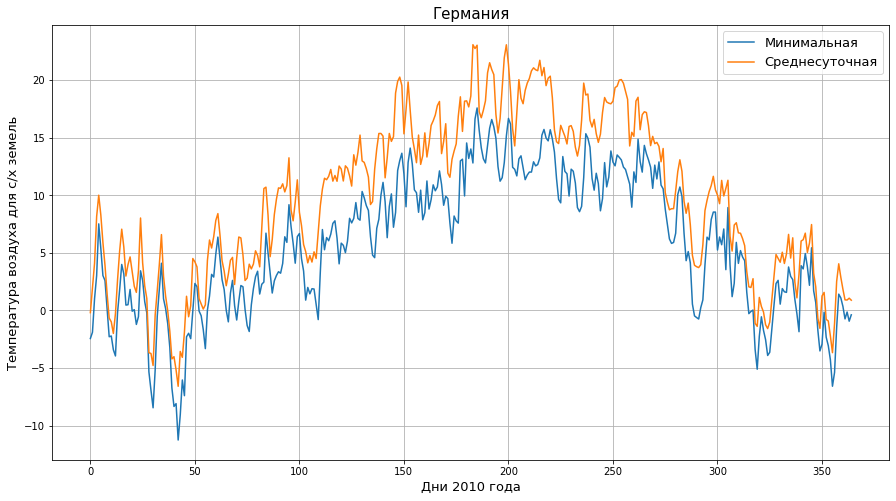

In [7]:
germany_data = germany.select('*').toPandas()
germany_tmp = np.array(germany_data['TMP'][0])
germany_mintmp = np.array(germany_data['MIN_TMP'][0])

# Для наглядности отрисуем данные
plt.plot(germany_mintmp, label = 'Минимальная')
plt.plot(germany_tmp, label = 'Среднесуточная')
plt.grid()
plt.xlabel('Дни 2010 года', fontsize = 13)
plt.ylabel('Температура воздуха для с/х земель', fontsize = 13)
plt.legend(fontsize = 13)
plt.title('Германия', fontsize = 15)
plt.show()